# Batched Smoke

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/grids/Batched_Smoke.ipynb)

This example runs multiple smoke simulations in parallel, varying inflow positions, rate, and obstacles.

In [ ]:
%pip install phiflow
from phi.jax.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.

We use a batch dimension `setting` to parallelize multiple simulations.
All quantities with this dimension vary across the different settings. All quantities without this dimension equal for all settings.

In [40]:
domain = Box(x=100, y=100)

settings = batch(setting=3)
inflow_rate = tensor([.1, .2, .3], settings)
inflow_x = tensor([40, 50, 60], settings)
obstacle_x = wrap([15, 50, 70], settings)  # this affects the pressure matrix -> use NumPy

<Figure size 864x360 with 3 Axes>

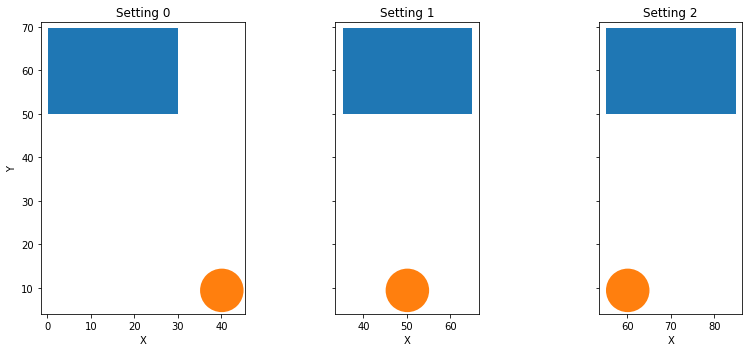

In [41]:
obstacle = Cuboid(vec(x=obstacle_x, y=60), half_size=vec(x=15, y=10))
inflow = Sphere(x=inflow_x, y=9.5, radius=5)
plot(obstacle, inflow, overlay='args')

From here on, we can copy the simulation code from the [smoke plume](Smoke_Plume.html) demo.

In [42]:
@jit_compile
def step(v, s, p, dt=1.):
    s = advect.mac_cormack(s, v, dt) + inflow_rate * resample(inflow, to=s, soft=True)
    buoyancy = resample(s * (0, 0.1), to=v)
    v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
    v, p = fluid.make_incompressible(v, obstacle, Solve(x0=p))
    return v, s, p

v0 = StaggeredGrid(0, 0, domain, x=64, y=64)
smoke0 = CenteredGrid(0, ZERO_GRADIENT, domain, x=200, y=200)
v_trj, s_trj, p_trj = iterate(step, batch(time=100), v0, smoke0, None)

In [44]:
plot(obstacle, inflow, s_trj, animate='time', overlay='args')